In [1]:
import networkx as nx
from SocialAnonymizer import SocialAnonymizer
from utils import plot_component, check_isomorphic_classes
import matplotlib.pyplot as plt

## Errors and failures

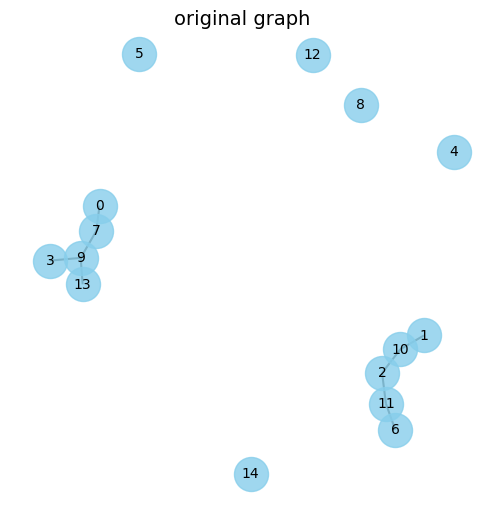

---------------------
Seed Vertex:  9
Processing group  [9, 11, 10, 7]
Processing pair 9-11
Processing pair 9-10
Synching changes to [11]
Processing pair 9-7
Synching changes to [11, 10]
---------------------
Seed Vertex:  2
Processing group  [2, 13, 8, 6]
Processing pair 2-13
Processing pair 2-8
Synching changes to [13]
Processing pair 2-6
Synching changes to [13, 8]
---------------------
Seed Vertex:  0
Processing group  [0, 14, 12, 5, 4, 3, 1]
Processing pair 0-14
Processing pair 0-12
Synching changes to [14]
Processing pair 0-5
Synching changes to [14, 12]
Processing pair 0-4
Synching changes to [14, 12, 5]
Processing pair 0-3
Synching changes to [14, 12, 5, 4]
Processing pair 0-1
Synching changes to [14, 12, 5, 4, 3]


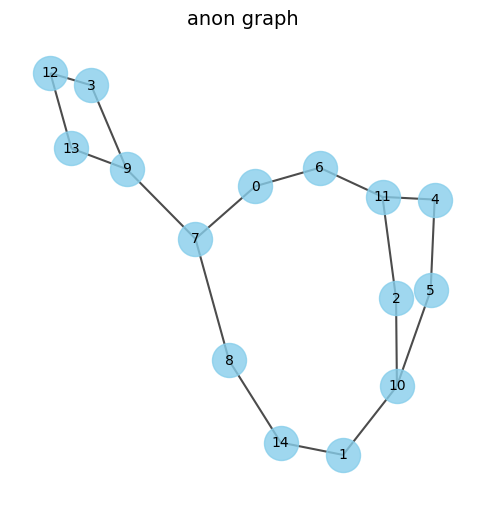

[]


In [2]:
G_random = nx.gnp_random_graph(n=15, p=0.1, seed=24)
plot_component(G_random, "original graph")
social_anonymizer = SocialAnonymizer()
G_anon, eq_dict = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
plot_component(G_anon, "anon graph")
print(check_isomorphic_classes(G_anon, eq_dict))

In [3]:
G_random = nx.gnp_random_graph(n=15, p=0.08, seed=15)
#plot_component(G_random, "original graph")
social_anonymizer = SocialAnonymizer()
G_anon, eq_dict = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
#plot_component(G_anon, "anon graph")
print(check_isomorphic_classes(G_anon, eq_dict))

---------------------
Seed Vertex:  12
Processing group  [12, 13, 9, 7]
Processing pair 12-13
Processing pair 12-9
Synching changes to [13]
Processing pair 12-7
!!! CONFLICT DETECTED: Node(s) {13} within current group modified.
!!! Restarting group processing...
Processing pair 12-13
Processing pair 12-9
Synching changes to [13]
Processing pair 12-7
!!! CONFLICT DETECTED: Node(s) {13} within current group modified.
!!! Restarting group processing...
Processing pair 12-13
Processing pair 12-9
Synching changes to [13]
Processing pair 12-7
!!! CONFLICT DETECTED: Node(s) {13} within current group modified.
!!! Restarting group processing...
Processing pair 12-13
Processing pair 12-9
Synching changes to [13]
Processing pair 12-7
!!! CONFLICT DETECTED: Node(s) {13} within current group modified.
!!! Restarting group processing...
Processing pair 12-13
Processing pair 12-9
!!! CONFLICT DETECTED: Node(s) {13} within current group modified.
!!! Restarting group processing...
Processing pair 12-

In [4]:
G_random = nx.gnp_random_graph(n=15, p=0.08, seed=4)
#plot_component(G_random, "original graph")
social_anonymizer = SocialAnonymizer()
G_anon, eq_dict = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
#plot_component(G_anon, "anon graph")
print(check_isomorphic_classes(G_anon, eq_dict))

---------------------
Seed Vertex:  12
Processing group  [12, 11, 10, 5]
Processing pair 12-11
Processing pair 12-10
Synching changes to [11]
Processing pair 12-5
Synching changes to [11, 10]
---------------------
Seed Vertex:  3
Processing group  [3, 14, 13, 9]
Processing pair 3-14
Processing pair 3-13
Synching changes to [14]
Processing pair 3-9
Synching changes to [14, 13]
---------------------
Seed Vertex:  5
Processing group  [5, 12, 11, 10]
Processing pair 5-12
Processing pair 5-11
Synching changes to [12]
Processing pair 5-10
!!! CONFLICT DETECTED: Node(s) {11} within current group modified.
!!! Restarting group processing...
Processing pair 5-12
Processing pair 5-11
Synching changes to [12]
Processing pair 5-10
!!! CONFLICT DETECTED: Node(s) {11, 12} within current group modified.
!!! Restarting group processing...
Processing pair 5-12


ValueError: min() iterable argument is empty

In [ ]:
import networkx as nx
from SocialAnonymizer import SocialAnonymizer
from utils import plot_component, check_isomorphic_classes
# i think in this situation the problem is that 3 is changing 1 which is part of the same anon class
fails = []
errors = []
for seed in range(50):
    G_random = nx.gnp_random_graph(n=15, p=0.08, seed= seed)
    #plot_component(G_random, "original graph")
    try:
        G_anon, eq_dict = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
        #plot_component(G_anon, "anon graph")
        if check_isomorphic_classes(G_anon, eq_dict) != []:
            fails.append(seed)
    except Exception as e:
        errors.append(seed)

print("Seeds that failed: ", fails)
print("Seeds that returned an error: ", errors)

---------------------
Seed Vertex:  11
Processing group  [11, 5, 3, 2]
Processing pair 11-5
Processing pair 11-3
Synching changes to [5]
Processing pair 11-2
Synching changes to [5, 3]
---------------------
Seed Vertex:  14
Processing group  [14, 13, 12, 10]
Processing pair 14-13
Processing pair 14-12
Synching changes to [13]
Processing pair 14-10
Synching changes to [13, 12]
---------------------
Seed Vertex:  9
Processing group  [9, 8, 7, 6, 4, 1, 0]
Processing pair 9-8
Processing pair 9-7
Synching changes to [8]
Processing pair 9-6
Synching changes to [8, 7]
Processing pair 9-4
Synching changes to [8, 7, 6]
Processing pair 9-1
Synching changes to [8, 7, 6, 4]
Processing pair 9-0
Synching changes to [8, 7, 6, 4, 1]
---------------------
Seed Vertex:  11
Processing group  [11, 1, 14, 10]
Processing pair 11-1
Processing pair 11-14
Synching changes to [1]
Processing pair 11-10
Synching changes to [1, 14]
---------------------
Seed Vertex:  9
Processing group  [9, 6, 3, 2]
Processing pai

Problema 1. Min iteration argument is empty in anonymize_pair and in sync_group_changes  
Problema 2. Parecchio lento

In [ ]:
# i think in this situation the problem is that 3 is changing 1 which is part of the same anon class
fails = []
errors = []

G_random = nx.gnp_random_graph(n=15, p=0.08, seed=11)
#plot_component(G_random, "original graph")
G_anon, eq_dict = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
#plot_component(G_anon, "anon graph")
print(check_isomorphic_classes(G_anon, eq_dict))

## Analysis

### 1. Temporal efficiency

The complexity of computing the Exact Minimum DFS Code is Factorial (O(N!)) in the worst case.   
The Worst Case is a Clique (Complete Graph). At Node 1, you have N−1 choices for the next step.
At Node 2, you have N−2 choices. This results in (N−1)! different DFS traces to compare. The search can be pruned by comparing the current trace with the currently best one found: if it results larger from the comparison, the search is pruned in that direction. 

In [ ]:
import time

# goal: evaluate the amount of time needed to execute a function

k_values = [2, 3, 4]
graph_sizes = [10, 15, 20, 25, 30]
num_of_repetition = 5
seed = 123

results = {k: [] for k in k_values}

for size in graph_sizes:
    
    for k in k_values:

        experiment_averages = []
        durations = []
        G = nx.gnp_random_graph(n=size, p=0.1, seed=seed)

        for _ in range(num_of_repetition):  # remove randomness of a single execution

            time_start = time.time()
            G_anon, eq_classes = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
            time_end = time.time()

            durations.append(time_end - time_start)

        duration_average = sum(durations) / len(durations)
        experiment_averages.append(duration_average)

        # Average over all experiments
        overall_average = sum(experiment_averages) / len(experiment_averages)

        results[k].append((size, overall_average))

plt.figure()

for k, data in results.items():
    sizes = [x[0] for x in data]
    times = [x[1] for x in data]

    plt.plot(sizes, times, marker='o', label=f"k = {k}")

plt.xlabel("Graph Size (Number of Nodes)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Scalability of Graph Anonymization Algorithm")
plt.legend()
plt.grid(True)
plt.show()

### 2. Graph Metrics

When it comes to graph, a lot of information is held also by **graph metrics**.    
Since we are dealing with social networks, node popularity (i.e., degree centrality) is particularly relevant as centrality metric. We'll be evaluating it along betweeness centrality, closeness, pagerank and reachability. We'll measure reachability as the number of connected components in the graph. As in Barabasi-Albert model, by construction, the graph is completely connected, such metric will be relevant only when considering random graphs as baseline or real social networks.     
The paper exploits two ways to anonymize the neighborhoods of vertices: generalizing vertex labels and adding edges. The 5 metrics above do not consider node labels, hence they will change after anonymization only because of edges modification. The information loss in graph metrics is only caused by edge addition.     
Since edges are ony added (and never removed), we can expect that, in general, graph metrics will change as follows:

1. the distribution of degree centrality starts as a power law distribution and it will tend to flatten. When anonymized into a clique, the distribution will be characterized by a single value, |V|-1, representing the degree of all the nodes. The closer is k to the number of nodes, the more evident the flattening effect. When k = |V|, every node will have the same degree value, which can be |V|-1 if anonymized into a clique or less if an isomoprhic pattern with less edges is found. 
2. the distribution of the betweeness in nodes from a hyperbolic shape in social networks (many nodes with low betweeness, few nodes with high betweeness) will tend to flatten and converge to a unique value as well. If the graph under analysis is anonymized into a clique, every node will have the same betweeness centrality value.  As for degree centrality, the higher is k the faster the distribution flattens. When k = |V|, every node will have the same betweeness centrality value. If the anonymized graph is connected, the betweeness centrality of all the nodes will be finite values. 
3. closeness will tend to increase. Adding edges reduces path length and makes nodes closer. 
4. enforcing k-neighborhood isomorphism by only adding edges tends to slightly redistribute PageRank from high-degree hubs to low-degree nodes, leading to a minor flattening of the PageRank distribution. Hubs remain dominant.
5. reachability tends to improve and the number of components to decrease.     

If K = |V| we find regular patterns. 

#### 2.1 Degree centrality

#### 2.2 Betweeness centrality

#### 2.3 Closeness centrality

#### 2.4 PageRank

#### 2.5 Reachability

### 3. Anonymization Cost

The anonymization cost defined in the paper depends on three parameters: alpha, beta and gamma. Alpha guides the influence of the information loss caused by labels generalization. Beta defines the relevance given to the loss caused by edge addition. Gamma is related to the addition of new nodes in the neighborhood instead. Changing these three parameters will change the anonymization cost. 

### 4. Query Ability

### 5. Privacy vs Utility

The trade-off between privacy and utility is quite evident in this scenario. 
- 1 utility, 0 privacy: original graph
- 1 privacy, 0 utility: clique with '*' as label for every node    

As previosuly discussed, we adopt two modifications for anonymization, of which one is perturbative (i.e., the addition of edges, which alters the truthness of data) and one is non-perturbative (i.e., the generalization of ndoe labels, which does not alter the truthness of data).